# CNN for morphological classifation of galaxies


In this project we use CNN to provide morphological classification of galaxies including in the SDSS survey (Sloan Digital Sky Survey). These galaxies have been classified morphologically using the [GalaxyZoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/) plataform using the so-called citizen-scientist. Briefly, the plataform presents to a user the image of a random galaxy with a comparison of typical morphological features of a galaxy (e.g., it is round-shaped? does it have arms? does it have a bar?). Given the fact for given galaxy this classification is performed by hundreds of users, it is significantly more robust in comparison to those derived by single or small group of astronomers. 

This project make use of the images reprocessed by the  [`astroNN`](wwww) package (see [Gharat & Dandawate, 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.511.5120G/abstract), and [Leung and Bovy, 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.483.3255L/abstract) for further information regarding tagging, and image downscaling). 


As in [Gharat & Dandawate, 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.511.5120G/abstract) we use 10 different morphological tags for classify the astroNN sample of galaxies. 

This code was developed as part of the optative lecture 'Data analysis for astronomy' held at the UNAM Astronomy Institute during the fall 2023 term.

Teachers:
* Jorge Barrera
* Joel Sanchez

Students:
* Eric Macías Estrada
* Mónica Alejandra Villa Durango
* Valeria Quintero Ortega
* Aurora Mata Sánchez



In colab we install the requred packages. For the training we use tensorflow

In [ ]:
!pip install tensorflow
!pip install tensorflow_probability
!pip install git+https://github.com/henrysky/astroNN.git

import numpy as np
from sklearn.model_selection import train_test_split
import pylab as plt
from astroNN.models import Galaxy10CNN
from astroNN.datasets import load_galaxy10sdss
from astroNN.datasets.galaxy10sdss import galaxy10cls_lookup, galaxy10_confusion
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as cns
from sklearn.metrics import confusion_matrix
import sklearn.metrics
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

  Cloning https://github.com/henrysky/astroNN.git to /tmp/pip-req-build-hbzvo2h8
  Running command git clone --filter=blob:none --quiet https://github.com/henrysky/astroNN.git /tmp/pip-req-build-hbzvo2h8
  Resolved https://github.com/henrysky/astroNN.git to commit 294dd6775550adc9aaece7355b72d3b2f1d9ed8f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.9/888.9 kB 23.3 MB/s eta 0:00:00
  Created wheel for astroNN: filename=astroNN-1.2.dev0-py3-none-any.whl size=9336512 sha256=bc2cf372604d0f58341533df3b709676de241fe8c1f6c0286db5b4c0fd5a5277
  Stored in directory: /tmp/pip-ephem-wheel-cache-fc9vnclq/wheels/22/d1/2b/2a4d4d76da90d8da884392aae60ad54592660343cb5b8942c7
Successfully built astroNN


In [ ]:
#Loading data
images, labels = load_galaxy10sdss()
# labels to categorical class
labels = utils.to_categorical(labels, 10)

#pre-processing
images=images/255
labels = labels.astype(np.float32)
images = images.astype(np.float32)

# Set train and test datasets

train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), train_size=0.8, test_size=0.2)
train_images, train_labels, test_images, test_labels = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]

Galaxy10.h5:  97%|█████████▋| 204M/210M [00:02<00:00, 74.3MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10.h5


Galaxy10.h5: 210MB [00:03, 52.9MB/s]                           


Our model consist of 4 CNNs, 3 Maxpooling, 3 Droput, 3 Fully connected NN and 1 flatten.

In [ ]:
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(69, 69, 3), kernel_regularizer=regularizers.l2(0.001)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(150, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(60, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 67, 67, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 65, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       2

In [ ]:
checkpoint = ModelCheckpoint(filepath='weights', monitor='val_loss', save_best_only=True)

In [ ]:
#Training the model

# Learning rate
lr = 0.001 
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optimizers.Adam(learning_rate=lr))
history = model.fit(train_images, train_labels, epochs=200, batch_size=64, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/200
218/218 [==============================] - 14s 55ms/step - loss: 1.3631 - accuracy: 0.5067 - val_loss: 1.2273 - val_accuracy: 0.5866
Epoch 2/200
218/218 [==============================] - 12s 56ms/step - loss: 1.2504 - accuracy: 0.5672 - val_loss: 1.1321 - val_accuracy: 0.6489
Epoch 3/200
218/218 [==============================] - 11s 52ms/step - loss: 1.1689 - accuracy: 0.6186 - val_loss: 1.0873 - val_accuracy: 0.6581
Epoch 4/200
218/218 [==============================] - 11s 52ms/step - loss: 1.0965 - accuracy: 0.6577 - val_loss: 1.0135 - val_accuracy: 0.6627
Epoch 5/200
218/218 [==============================] - 11s 51ms/step - loss: 1.0222 - accuracy: 0.6940 - val_loss: 0.9285 - val_accuracy: 0.7260
Epoch 6/200
218/218 [==============================] - 11s 50ms/step - loss: 0.9986 - accuracy: 0.7029 - val_loss: 0.8939 - val_accuracy: 0.7413
Epoch 7/200
218/218 [==============================] - 11s 51ms/step - loss: 0.9607 - accuracy: 0.7158 - val_loss: 0.8919 - val_ac

<ipython-input-19-e142f18118b1>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
<ipython-input-19-e142f18118b1>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-.b" (-> color='b'). The keyword argument will take precedence.
<ipython-input-19-e142f18118b1>:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
<ipython-input-19-e142f18118b1>:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-.r" (-> color='r'). The keyword argument will take precedence.


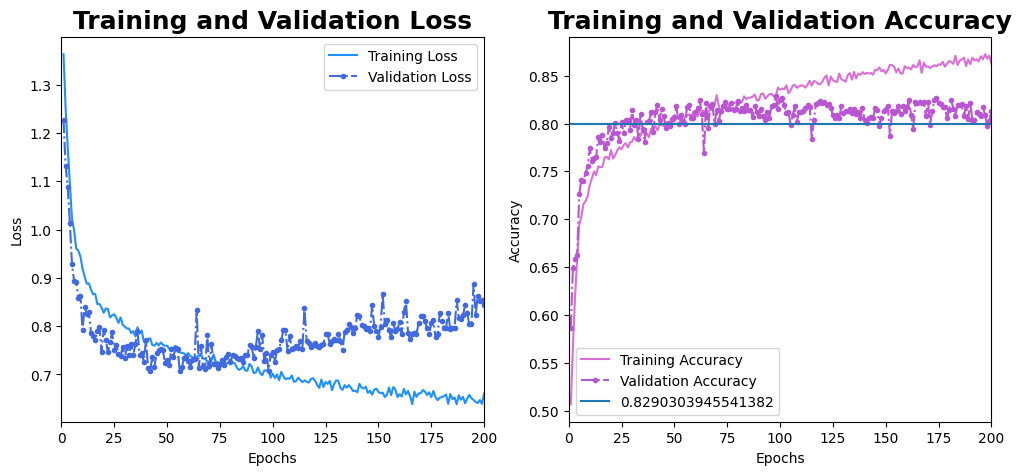

In [ ]:
# Loss and validation plots

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training Loss',color='dodgerblue')
plt.plot(epochs, val_loss, '.-.b', label='Validation Loss',color='royalblue')
plt.title('Training and Validation Loss', size=18,weight="bold")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0,200)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'r', label='Training Accuracy',color='orchid')
plt.plot(epochs, val_accuracy, '.-.r', label='Validation Accuracy',color='mediumorchid')
plt.title('Training and Validation Accuracy',size=18, weight="bold")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0,200)
plt.legend()


In [ ]:
#Model testing
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
test_class = np.argmax(test_labels, axis=1)


137/137 [==============================] - 1s 8ms/step - loss: 0.8506 - accuracy: 0.8006


In [ ]:
#confusion matrix
confusion_matrix = np.zeros((10,10))
for counter, i in enumerate(predicted_labels):
    confusion_matrix[i, test_class[counter]] += 1

137/137 [==============================] - 1s 6ms/step


In [ ]:
def plot_cm(Y_reales,Y_predichos, labels, porcentaje=False):
    matrix = sklearn.metrics.confusion_matrix(Y_reales.argmax(axis=1), Y_predichos.argmax(axis=1))

    cmapc  = 'RdPu'
    if porcentaje==False:
      ax = cns.heatmap(matrix, annot=True, cmap= cmapc, cbar_kws={'label': 'scale of successes'})
      plt.title("Confusion matrix (successes)",size=25,weight="bold")
    if porcentaje==True:
        plt.title("Confusion matrix (percentage)",size=25,weight="bold")
        m=np.zeros(matrix.shape)
        for j in range(0,matrix.shape[1]):
            m[:,j]=matrix[:,j]/np.sum(matrix[:,j])
        ax = cns.heatmap(m, annot=True,fmt='.2%',
                                          cmap= cmapc, cbar_kws={'label': 'scale of percentage'})

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    ax.set(xlabel="True label", ylabel="Predicted label")

137/137 [==============================] - 1s 7ms/step


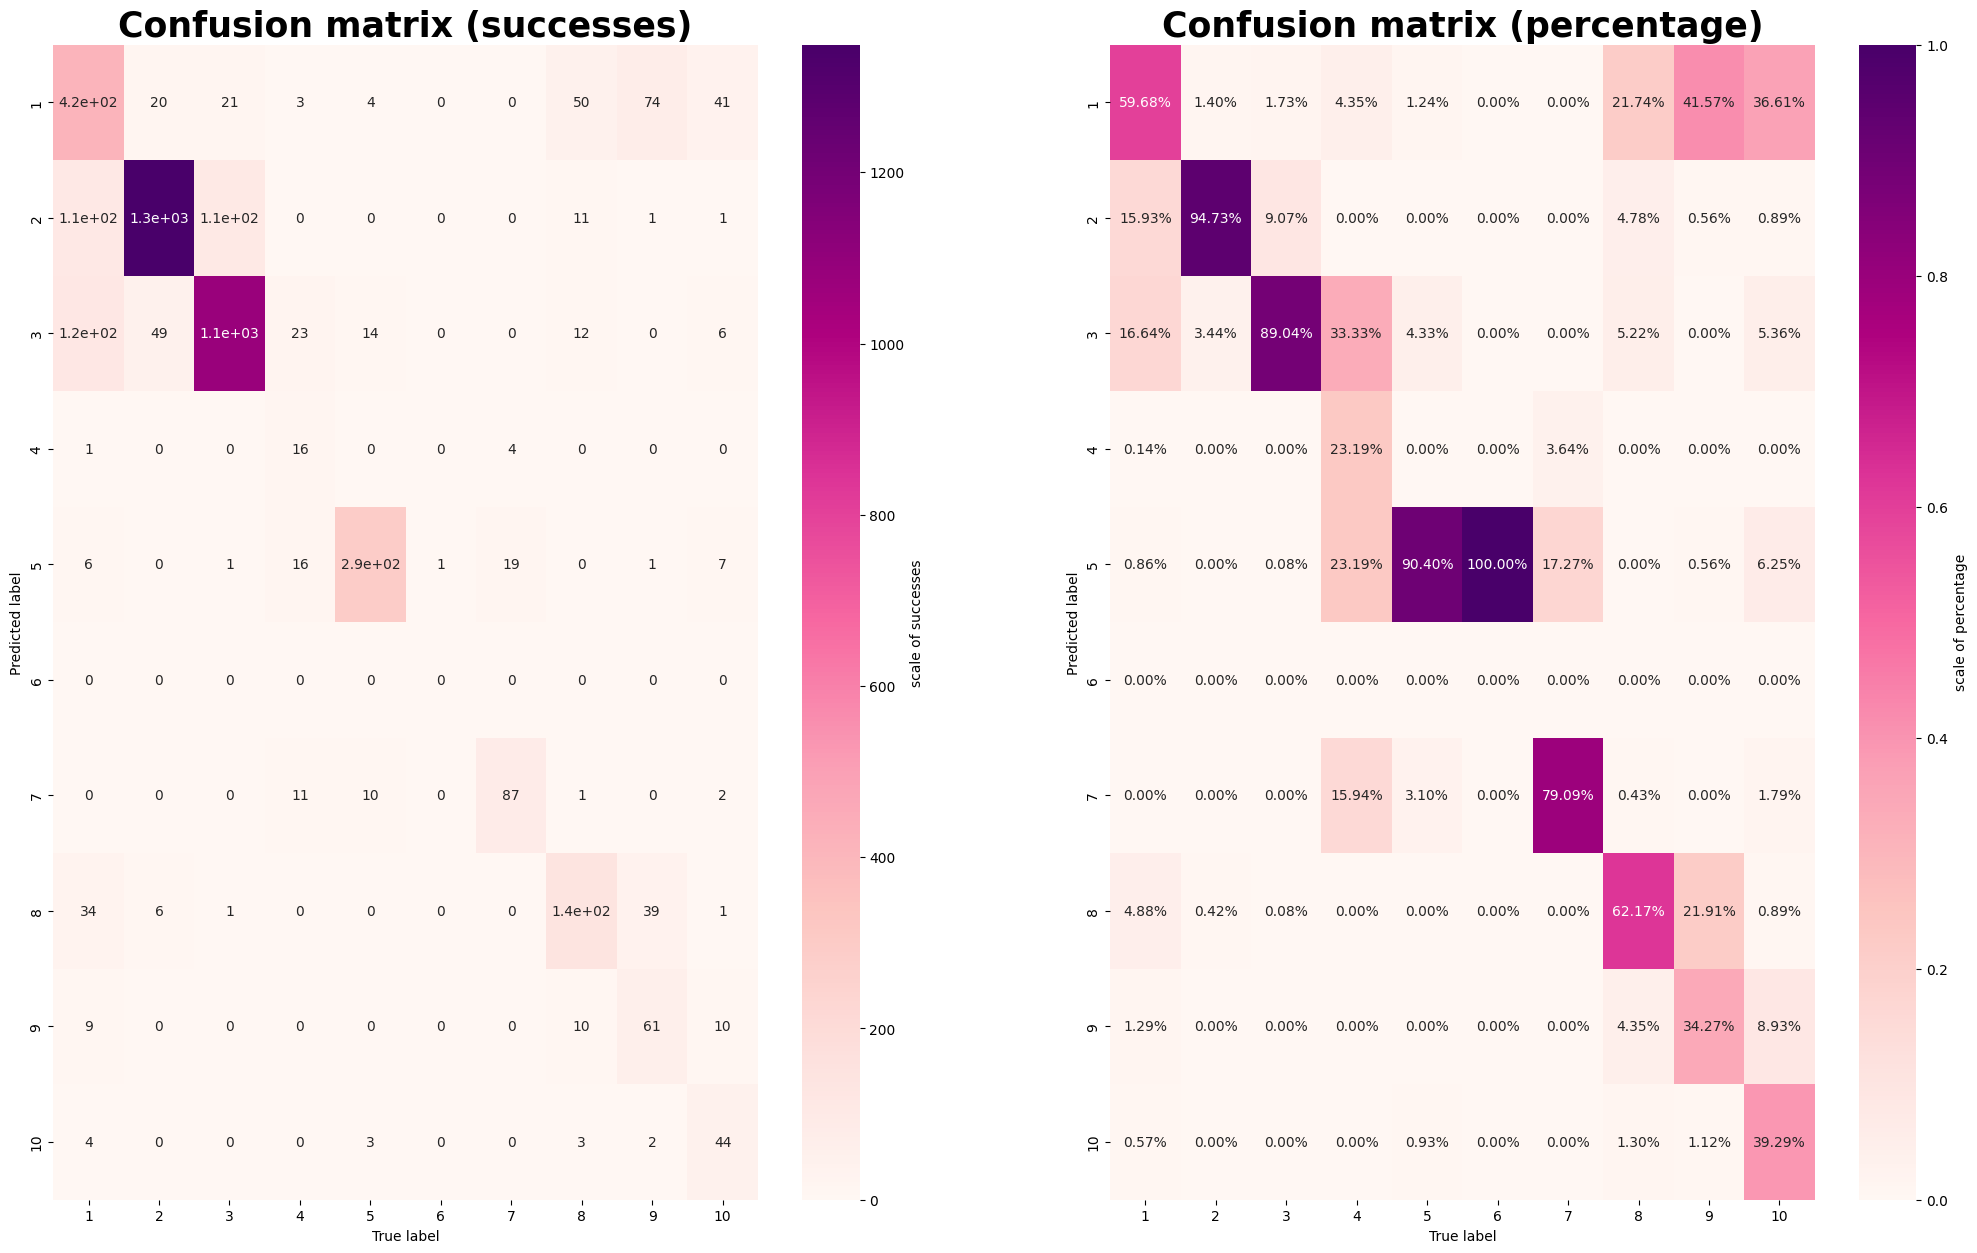

In [ ]:
plt.figure(figsize=(25,15))

plt.subplot(1, 2, 1)
labels=['1','2', '3', '4', '5', '6', '7', '8', '9', '10']
plot_cm(model.predict(test_images),test_labels, labels, porcentaje=False)

plt.subplot(1,2,2)
labels=['1','2', '3', '4', '5', '6', '7', '8', '9', '10']
plot_cm(model.predict(test_images),test_labels, labels, porcentaje=True)